# 10. 画像処理分野

## 概要

本演習では ResNet の Residual Block を穴埋め形式で実装します。

なお、予め用意されたコードはそのまま使用し、指示された穴埋め部を編集してください。  
演習問題文は<font color="Red">赤字</font>です。

また、乱数設定により実行結果が異なるため、<font color="Red">コードを完成させたあと、必ずもう一度一番上のセルから順に最後まで実行して結果を確認してください。</font>

所要時間：<font color="Red">5~8時間</font>

### 【Google colabのみ実行】ライブラリのインストール

必要なライブラリのインストールと、実行環境のバージョンを統一します。<br>

使用するライブラリ名とバージョンは配布資料の<font color=Red>「requirements.txt」</font>で確認できます。

※以下のセルを実行しましたら、「ランタイム」→「ランタイムを再起動」により<font color=Red>再起動</font>を行ってください。

In [21]:
import sys
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # ライブラリのインストール
    !pip install tensorflow==2.8.0
else:
    print("Not Google Colab")

Not Google Colab


### ライブラリのインポート

必要なライブラリのインストールを行います。

In [46]:
import numpy as np
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.utils import data_utils

try:
    from tqdm.notebook import tqdm
except:
    from tqdm import tqdm_notebook as tqdm
    
np.random.seed(1)
tf.random.set_seed(1)

# GPU が利用できる場合は、GPU上で学習を行います。
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### データセットの準備

データセットには、cifar10 を使用します。

cifar10 は10種類のクラスを含まれており、  
学習データ 50000枚、テストデータ 10000枚で構成されています。

データは 3チャンネル(RGB)の縦横 32×32 の配列`(3, 32, 32)`となっています。

本演習では実行時間の関係上、飛行機と自動車の画像500枚ずつに限定して学習します。

In [47]:
# 画像データを標準化する際の平均と分散、およびバッチサイズ
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
batch_size = 8

num_data = 500
num_classes = 2

# テストデータのダウンロード
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()


# 学習データから飛行機と自動車の画像を抽出
mini_data = [[] for x in range(num_classes)]
idx_list = list(range(2))
for img, tgt in zip(x_train, y_train):
    if tgt in idx_list and len(mini_data[int(tgt)]) < num_data:
        mini_data[int(tgt)].append(img)
mini_data = np.array(mini_data, dtype=x_train.dtype).reshape(-1, 32, 32, 3)

# 学習データ用の正解ラベルを作成
mini_targets = []
for i in idx_list:
    tgt = [i] * num_data
    mini_targets += tgt

# 学習データに適用する前処理
data_augmentation = tf.keras.Sequential([
  layers.Resizing(224, 224),                      # 短い辺の長さがresizeの大きさになる
  layers.RandomFlip(mode='horizontal', seed=1),   # ランダムに左右に反転する
  layers.Rescaling(1./255),                       #[0, 255]の範囲にある入力データを[0, 1]の範囲に再スケールする
  layers.Normalization(mean=mean, variance=std)   # 色情報の標準化
])
mini_data = data_augmentation(mini_data)

# テストデータのデータローダ
train_ds = tf.data.Dataset.from_tensor_slices((mini_data,mini_targets)).shuffle(10000).batch(batch_size)

## 1. ResNetを用いたCIFAR10の分類

### ResNetについて

CNNでは多層化することでネットワークの表現能力が向上することが知られているが、同時に入力層付近で勾配消失が起こりうまく学習できなくなってしまうという問題や勾配消失以外にも単純に層を深くすると反って精度が悪くなってしまうという劣化問題もあります。

ResNetのResidual Blockは勾配消失や劣化問題に対して、skip connectionを導入することで勾配が出力層から入力層まで消失することなく伝播できるようになり、ネットワークをより多層化することができました。

### bottleneckのアーキテクチャ

3層の畳み込み層とskip connectionから構成されます。
図の例では、256次元の特徴マップが入力された場合の構造を示しています。

この構造のポイントは、
- 1層目と二層目の畳み込み層で次元数を減少させることで、必要なパラメータ数を削減している。
- 3層目の次元数を復元することで、最終的に得られる特徴マップのサイズはPlainアーキテクチャと同じになる。

このような構造により、同じパラメータ数で多層化することができるという利点があります。

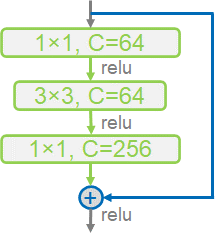

また、重要な特徴表現を獲得するためには、次元数を増加させる必要があります。そのため、ResNetでは一部のレイヤーでダウンサンプリングしてから次元数を増やす処理を行っています。

### ResNet の実装

ライブラリでは、VGG や ResNet など有名なネットワークはすでに実装されていて、手軽に利用できます。  
本演習では理解のために ResNet の Residual Block のみを自ら実装してみましょう。  
また、今回扱う Residual Block は Bottleneck アーキテクチャになります。

* <font color="Red">問1. ResNet の Bottleneckレイヤー を完成させてください。</font>
  * <font color="Red">問1-1. ダウンサンプリングを行う処理を記述してください。<br>
    なお、コード入力の際は下記コードの```[a]```および```[b]```の部分に適切な変数または数値を入力してから転記してください。</font><br>
      * 問1-1-1 ```layers.Conv2D([a-1], [b-1], strides=stride, name=name + '_1_conv')(x)```<br>
      * 問1-1-2 ```layers.Conv2D([a-2], [b-2], padding='SAME', name=name + '_2_conv')(x)```<br>
      * 問1-1-3 ```layers.Conv2D([a-3], [b-3], name=name + '_3_conv')(x)```<br>
  * <font color="Red">問1-2. skip connectionを行う処理を記述してください。</font>

【ヒント】
skip connectionは畳み込み層の出力`x`と層をまたいだ`shortcut`を足し合わせる処理です。

In [4]:
# def Convolution(x, filters, stride=1):
#     x = layers.Conv2D(filters, 5, strides=stride)(x)
#     x = layers.Activation('relu')(x)
    
#     x = layers.Conv2D(2*filters, 5, strides=stride)(x)
#     x = layers.Activation('relu')(x)

In [68]:
def Bottleneck(x, filters, stride=1, conv_shortcut=True, name=None):
    bn_axis = 3 if tf.keras.backend.image_data_format() == 'channels_last' else 1

    if conv_shortcut:
        shortcut = layers.Conv2D(4 * filters, 1, strides=stride, name=name + '_0_conv')(x)
        shortcut = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_0_bn')(shortcut)
    else:
        shortcut = x

    x = layers.Conv2D(filters, kernel_size=1, strides=1, name=name + '_1_conv')(x)###問1-1-1###
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)

    x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='SAME', name=name + '_2_conv')(x)###問1-1-2###
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)

    x = layers.Conv2D(4 * filters, kernel_size=1, strides=1, name=name + '_3_conv')(x)###問1-1-3###
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_3_bn')(x)

    x = layers.Add()([shortcut, x])###問1-2###
    x = layers.Activation('relu', name=name + '_out')(x)
    return x

上記で実装した Bottleneck を用いて、ResNet50 を実装します。

In [69]:
def myResNet50(classes=1000,model_name='resnet50'):
    classifier_activation = 'softmax'
    img_input = layers.Input(shape=(224,224,3))
    bn_axis = 3 if tf.keras.backend.image_data_format() == 'channels_last' else 1

    x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, 7, strides=2, name='conv1_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='conv1_bn')(x)
    x = layers.Activation('relu', name='conv1_relu')(x)
    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='pool1_pad')(x)
    x = layers.MaxPooling2D(3, strides=2, name='pool1_pool')(x)

    x = Bottleneck(x, 64, name='conv2_block1')
    x = Bottleneck(x, 64, conv_shortcut=False, name='conv2_block2')
    x = Bottleneck(x, 64, conv_shortcut=False, name='conv2_block3')
    x = Bottleneck(x, 128, stride=2, name='conv3_block1')
    x = Bottleneck(x, 128, conv_shortcut=False, name='conv3_block2')
    x = Bottleneck(x, 128, conv_shortcut=False, name='conv3_block3')
    x = Bottleneck(x, 128, conv_shortcut=False, name='conv3_block4')
    x = Bottleneck(x, 256, stride=2, name='conv4_block1')
    x = Bottleneck(x, 256, conv_shortcut=False, name='conv4_block2')
    x = Bottleneck(x, 256, conv_shortcut=False, name='conv4_block3')
    x = Bottleneck(x, 256, conv_shortcut=False, name='conv4_block4')
    x = Bottleneck(x, 256, conv_shortcut=False, name='conv4_block5')
    x = Bottleneck(x, 256, conv_shortcut=False, name='conv4_block6')
    x = Bottleneck(x, 512, stride=2, name='conv5_block1')
    x = Bottleneck(x, 512, conv_shortcut=False, name='conv5_block2')
    x = Bottleneck(x, 512, conv_shortcut=False, name='conv5_block3')

    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dense(classes, activation=classifier_activation,name='predictions')(x)

  # Create model
    model =  tf.keras.Model(img_input, x, name=model_name)
    return model

#ResNet50の実装
my_ResNet50 = myResNet50()

### 転移学習

ResNet では、転移学習 を行います。

転移学習とは、事前学習で得られたパラメータを固定し、新たに追加した層のみを学習する手法です。

まずは、TensorFlow で配布されている事前学習パラメータを読み込みます。

In [70]:
BASE_WEIGHTS_PATH = ('https://storage.googleapis.com/tensorflow/keras-applications/resnet/')
file_name = 'resnet50_weights_tf_dim_ordering_tf_kernels.h5'
file_hash = '2cb95161c43110f7111970584f804107'
weights_path = data_utils.get_file(file_name,BASE_WEIGHTS_PATH + file_name,cache_subdir='models',file_hash=file_hash)
my_ResNet50.load_weights(weights_path)    # 事前学習パラメータの読み込み

TensorFlow に実装されている ResNet50 の出力層は 1000クラスを分類するようになっています。  
しかし、本演習では飛行機と自動車の 2クラス分類のため出力層を追加する必要があります。

<font color="Red">問2. 2クラス分類を行うために出力層を変更してください。出力サイズは`2`とします。</font>

【ヒント】

`outputs = my_ResNet50.get_layer('avg_pool').output` では「avg_pool」という名前のlayerの出力を取得しています。

In [74]:
sub_model = tf.keras.Model(inputs = my_ResNet50.input, outputs = my_ResNet50.get_layer('avg_pool').output)
inputs = sub_model.input
x = sub_model(inputs)
x = layers.Dense(units=2, activation = 'sigmoid',name='predictions')(x)###問2###
new_ResNet50 = tf.keras.Model(inputs,x)

model_resnet50 の160層以上のパラメータのみを学習によって最適化します

<font color="Red">問3. 学習率`lr=0.001`, モーメンタム`momentum=0.9`で最適化アルゴリズム`SGD`を完成させてください。</font>

【ヒント】`model_resnet50` の160番目までの層の`.trainable`の引数を`False`に与える。

In [75]:
for layer in new_ResNet50.layers[-2].layers[0:160]:
    layer.trainable =  False

In [76]:
# oprimizer
optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)###問3###
# 損失関数
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
#損失の計算
train_loss = tf.keras.metrics.Mean(name='train_loss')
#精度の計算
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

C:\Users\mssst\miniconda3\envs\avilen-e\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


### 学習

５エポックで精度が80%以上になっていれば学習成功です。

学習には、GPU環境で2~3分ほどかかります。

GPU環境でない場合、学習にかなりの時間が必要になると思われます。  
Google ColabのGPU環境で実行することを推奨します。

In [77]:
@tf.function
def train_step(x, labels):
    with tf.GradientTape() as tape:
        predictions = new_ResNet50(x, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss,new_ResNet50.trainable_variables)
    optimizer.apply_gradients(zip(gradients, new_ResNet50.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

EPOCHS = 5
loss_list = []
for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    for x, labels in tqdm(train_ds):
        train_step(x, labels)
    print(f'Epoch {epoch + 1}, 'f'Loss: {train_loss.result()}, 'f'Accuracy: {train_accuracy.result() * 100}, ')
    loss_list.append(train_loss.result())


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1, Loss: 0.522720217704773, Accuracy: 72.5999984741211, 


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2, Loss: 0.3947025239467621, Accuracy: 82.20000457763672, 


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3, Loss: 0.43258044123649597, Accuracy: 81.5, 


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4, Loss: 0.38440871238708496, Accuracy: 84.0, 


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5, Loss: 0.2986506223678589, Accuracy: 86.0999984741211, 



## 2. WideResNetを用いたCIFAR10の分類

### WideResNetについて

WideResNetは、ResNetの層数を減らし各層の次元数を増加させることで精度を向上させるネットワークになっています。

このような変更を加えたメリットとして以下が挙げられます。
- 次元数を増やすことで、層数が少なくても十分な特徴表現を獲得できる。
- 畳み込み層は、次元数が増えたとしても並列計算できるためあまりの計算コストが増加しない。WideResNetではその分層数を減らしているため、より計算コストを削減することができる。

また、層を深くしたWideResNetでは畳み込み層の間にDropoutを用いることで、精度が向上することも報告されている。

### bottleneckのアーキテクチャ

WideResNetのbottleneckとResnetのbottleneckの違いは、畳み込み層の2層目の次元数をk倍している部分です。

以下の図の例では、`k=2`を採用しています。

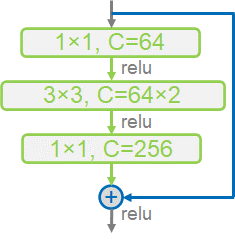

### WideResNet の実装

ResNet に引き続き、WideResNet も Residual Block のみを自ら実装してみましょう。  
ResNet 同様、Residual Block は Bottleneck アーキテクチャになります。

* <font color="Red">問4. WideResNet の Bottleneckレイヤー を完成させてください。</font>
  * <font color="Red">問4-1. ダウンサンプリングを行う処理を記述してください。<br>
    なお、コード入力の際は下記コードの```[a]```および```[b]```の部分に適切な変数または数値を入力してから転記してください。</font><br>
      * 問4-1-1 ```layers.Conv2D([a-1], [b-1], strides=stride, name=name + '_1_conv')(x)```<br>
      * 問4-1-2 ```layers.Conv2D([a-2], [b-2], padding='SAME', name=name + '_2_conv')(x)```<br>
      * 問4-1-3 ```layers.Conv2D([a-3], [b-3],name=name + '_3_conv')(x)```<br>
  * <font color="Red">問4-2. skip connectionを行う処理を記述してください。</font>


In [83]:
def WideBottleneck(x, filters, stride=1, conv_shortcut=True, name=None):
    bn_axis = 3 if tf.keras.backend.image_data_format() == 'channels_last' else 1

    if conv_shortcut:
        shortcut = layers.Conv2D(4 * filters, 1, strides=stride,name=name + '_0_conv')(x)
        shortcut = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,name=name + '_0_bn')(shortcut)
    else:
        shortcut = x

    x = layers.Conv2D(filters, kernel_size=1, strides=stride, name=name + '_1_conv')(x)###問4-1-1###
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)

    x = layers.Conv2D(2 * filters, kernel_size=3, padding='SAME', name=name + '_2_conv')(x)###問4-1-2###
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)

    x = layers.Conv2D(4 * filters, kernel_size=1,name=name + '_3_conv')(x)###問4-1-3###
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_3_bn')(x)

    x = layers.Add()([shortcut, x])###問4-2###
    x = layers.Activation('relu', name=name + '_out')(x)
    return x

上記で実装した WideBottleneck を用いて、WideResNet50 を実装します。

In [84]:
def myWideResNet50(classes=1000,model_name='resnet50'):
    classifier_activation = 'softmax'
    img_input = layers.Input(shape=(224,224,3))
    bn_axis = 3 if tf.keras.backend.image_data_format() == 'channels_last' else 1

    x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, 7, strides=2, name='conv1_conv')(x)
    x = layers.BatchNormalization(
        axis=bn_axis, epsilon=1.001e-5, name='conv1_bn')(x)
    x = layers.Activation('relu', name='conv1_relu')(x)
    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='pool1_pad')(x)
    x = layers.MaxPooling2D(3, strides=2, name='pool1_pool')(x)

    x = WideBottleneck(x, 64, name='conv2_block1')
    x = WideBottleneck(x, 64, conv_shortcut=False, name='conv2_block2')
    x = WideBottleneck(x, 64, conv_shortcut=False, name='conv2_block3')
    x = WideBottleneck(x, 128, stride=2, name='conv3_block1')
    x = WideBottleneck(x, 128, conv_shortcut=False, name='conv3_block2')
    x = WideBottleneck(x, 128, conv_shortcut=False, name='conv3_block3')
    x = WideBottleneck(x, 128, conv_shortcut=False, name='conv3_block4')
    x = WideBottleneck(x, 256, stride=2, name='conv4_block1')
    x = WideBottleneck(x, 256, conv_shortcut=False, name='conv4_block2')
    x = WideBottleneck(x, 256, conv_shortcut=False, name='conv4_block3')
    x = WideBottleneck(x, 256, conv_shortcut=False, name='conv4_block4')
    x = WideBottleneck(x, 256, conv_shortcut=False, name='conv4_block5')
    x = WideBottleneck(x, 256, conv_shortcut=False, name='conv4_block6')
    x = WideBottleneck(x, 512, stride=2, name='conv5_block1')
    x = WideBottleneck(x, 512, conv_shortcut=False, name='conv5_block2')
    x = WideBottleneck(x, 512, conv_shortcut=False, name='conv5_block3')

    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dense(classes, activation=classifier_activation,name='predictions')(x)

  # Create model
    model =  tf.keras.Model(img_input, x, name=model_name)
    return model

#WideResNet50の実装
my_WideResNet50 = myWideResNet50()

さらに、2クラス分類に2クラス分類のため出力層を追加しましょう。

<font color="Red">問5. 2クラス分類を行うために出力層を追加してください。</font>

In [85]:
sub_wide_model = tf.keras.Model(inputs = my_WideResNet50.input, outputs =my_WideResNet50.get_layer('avg_pool').output)
inputs = sub_wide_model.input
x = sub_wide_model(inputs)
x = layers.Dense(units=2, activation = 'sigmoid',name='predictions')(x)###問5###
new_WideResNet50 = tf.keras.Model(inputs,x)

<font color="Red">問6. 学習率`lr=0.001`, モーメンタム`momentum=0.9`で最適化アルゴリズム`SGD`を完成させてください。</font>

In [86]:
# oprimizer
optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)###問6###
# 損失関数
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
#損失の計算
train_loss = tf.keras.metrics.Mean(name='train_loss')
#精度の計算
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

### 学習

５エポックで精度が80%以上になっていれば学習成功です。学習には、GPU環境で6～8分ほどかかります。

GPU環境でない場合は、学習に60～90分ほど必要になります。Google ColabのGPU環境で実行することを推奨します。

In [87]:
@tf.function
def train_step(x, labels):
    with tf.GradientTape() as tape:
        predictions = new_WideResNet50(x, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, new_WideResNet50.trainable_variables)
    optimizer.apply_gradients(zip(gradients, new_WideResNet50.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

EPOCHS = 5
loss_list = []
for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    for x, labels in tqdm(train_ds):
        train_step(x, labels)
    print(f'Epoch {epoch + 1}, 'f'Loss: {train_loss.result()}, 'f'Accuracy: {train_accuracy.result() * 100}, ')
    loss_list.append(train_loss.result())


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1, Loss: 1.0645830631256104, Accuracy: 65.9000015258789, 


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2, Loss: 0.7358579635620117, Accuracy: 72.29999542236328, 


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3, Loss: 0.7736756801605225, Accuracy: 76.30000305175781, 


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4, Loss: 0.6524447202682495, Accuracy: 78.19999694824219, 


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5, Loss: 0.6020799875259399, Accuracy: 81.19999694824219, 
